## Здесь ячейки с подгрузкой библиотек и результатов предыдущего этапа.
Всё выполняется быстро, обучение модели не происходит, только загрузка её из сохранённых

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import random 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu
%matplotlib inline

c:\Users\Sergey\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Параметры

In [3]:
DATSET_NAME = "camvid-dataset"

X_TRAIN_DIR = f"{DATSET_NAME}/Train"
Y_TRAIN_DIR = f"{DATSET_NAME}/Trainannot"

X_VALID_DIR = f"{DATSET_NAME}/Validation"
Y_VALID_DIR = f"{DATSET_NAME}/Validationannot"

X_TEST_DIR = f"{DATSET_NAME}/Validation"
Y_TEST_DIR = f"{DATSET_NAME}/Validationannot"

LABEL_COLORS_FILE = f"{DATSET_NAME}/label_colors.txt"

Задание констант:

In [4]:
CLASSES = [
    "background",
    "item"  
]
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 70
BATCH_SIZE = 32

INIT_LR = 0.0005
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2

INFER_WIDTH = 256
INFER_HEIGHT = 256

loss = utils.losses.DiceLoss()

### Вспомогательные функции

In [5]:
def _convert_multichannel2singlechannel(mc_mask: np.ndarray):
    colors_imshow = {
            "background" : np.array([0, 0, 0]),
            "item" : np.array([87, 170, 197])
    }

    sc_mask = np.zeros((mc_mask[0].shape[0], mc_mask[0].shape[1], 3), dtype=np.uint8)
    square_ratios = {}

    for i, singlechannel_mask in enumerate(mc_mask):

        cls = CLASSES[i]
        singlechannel_mask = singlechannel_mask.squeeze()
        square_ratios[cls] = singlechannel_mask.sum() / singlechannel_mask.size
        
        sc_mask += np.multiply.outer(singlechannel_mask > 0, colors_imshow[cls]).astype(np.uint8)
        

    title = "Площади: " + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    return sc_mask, title


def visualize_multichennel_mask(img: np.ndarray, multichennel_mask: np.ndarray):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    multichennel_mask = multichennel_mask.transpose(2, 0, 1)
    mask_to_show, title = _convert_multichannel2singlechannel(multichennel_mask)
    axes[1].imshow(mask_to_show)
    axes[1].set_title(title)

    plt.tight_layout()
    plt.show()

### Dataloader

In [6]:
class Dataset(BaseDataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        augmentation=None,
        preprocessing=None
    ):
        self.images_paths = glob(f"{images_dir}/*")
        self.masks_paths = glob(f"{masks_dir}/*")

        self.cls_colors = self._get_classes_colors(LABEL_COLORS_FILE)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def _get_classes_colors(self, label_colors_dir):
        cls_colors = {}
        with open(label_colors_dir) as file:
            while line := file.readline():
                R, G, B, label = line.rstrip().split()
                cls_colors[label] = np.array([B, G, R], dtype=np.uint8)

        keyorder = CLASSES
        cls_colors_ordered = {}
        for k in keyorder:
            if k in cls_colors:
                cls_colors_ordered[k] = cls_colors[k]
            elif k=="background":
                cls_colors_ordered[k] = np.array([0, 0, 0], dtype=np.uint8)
            else:
                raise ValueError(f"unexpected label {k}, cls colors: {cls_colors}")

        return cls_colors_ordered

    def __getitem__(self, i):
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[i])
        masks = [cv2.inRange(mask, color, color) for color in self.cls_colors.values()]
        masks = [(m > 0).astype("float32") for m in masks]
        mask = np.stack(masks, axis=-1).astype("float")

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images_paths)

Демонстрация случайных фотографий тренировочного датасета с их масками:

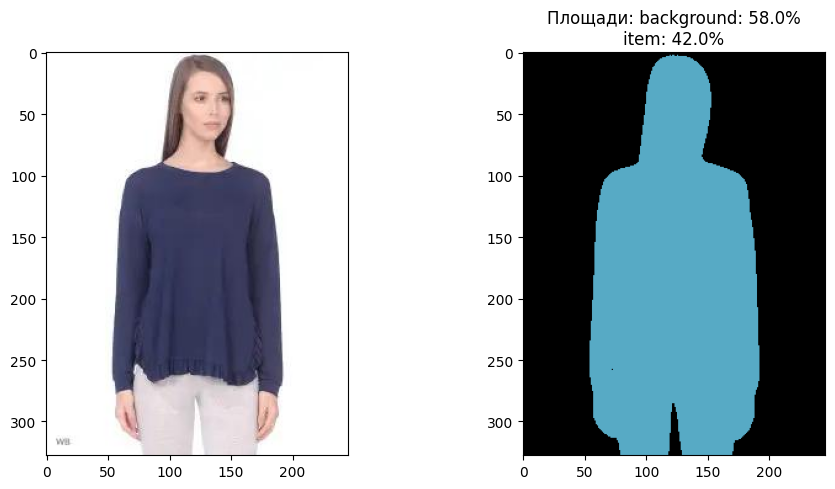

In [7]:
dataset = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
image, mask = dataset[np.random.randint(len(dataset))]
visualize_multichennel_mask(image, mask)

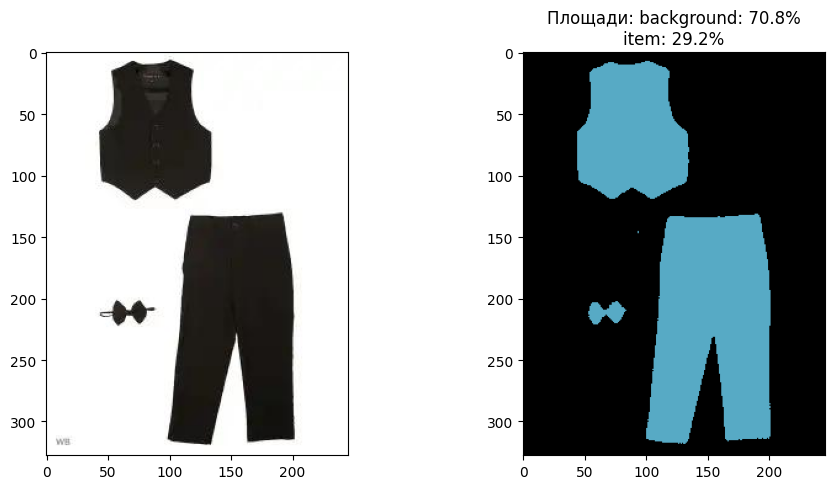

In [8]:
dataset2 = Dataset(X_VALID_DIR, Y_VALID_DIR)
image2, mask2 = dataset[np.random.randint(len(dataset))]
visualize_multichennel_mask(image2, mask2)

### Augmentations

In [9]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        #albu.SchiftScaleRotate()
        
        albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=1, always_apply=True),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.1, 0.2), lightness=(0.1, 0.2), p=0.5),
                albu.Blur(blur_limit=[1, 3], p=0.5),
                albu.GaussNoise(var_limit=(1, 5), p=0.5),
            ],
            p=0.7,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5), 
            ],
            p=0.7,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),]
    #albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=1, always_apply=True),
    #albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Пример аугментаций на val:

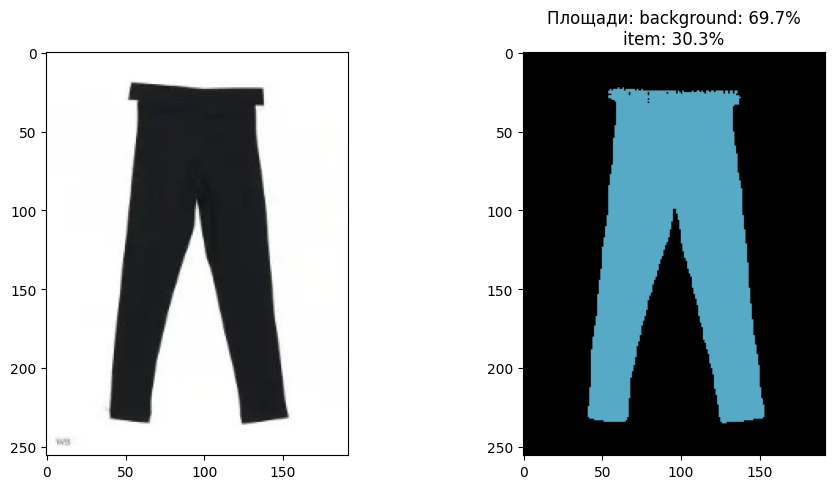

In [16]:
augmented_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

image, mask = augmented_dataset[indx]
visualize_multichennel_mask(image, mask)

### Create model and train

In [17]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [18]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Загрузка нормализации от imagenet

In [19]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
#preprocessing_fn = lambda img, **kwargs: img.astype("float32") / 255    # или классика деление на 255

In [20]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x00000219F33DC360>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [21]:
train_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [22]:
metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=INIT_LR),
])

In [23]:
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [24]:
# load best saved checkpoint
#best_model = torch.load('models/best_model_new.pth')
best_model = torch.jit.load('models/best_model_new.pt', map_location=DEVICE)

In [88]:
def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=1, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)

In [25]:
# оценка IoU
test_dataset = Dataset(
    X_TEST_DIR, 
    Y_TEST_DIR, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid:   0%|          | 0/50 [00:00<?, ?it/s]

valid: 100%|██████████| 50/50 [00:01<00:00, 32.58it/s, dice_loss - 0.03002, fscore - 0.9704, iou_score - 0.947]  


## Теперь получена модель и можно приступать к замене фона

In [38]:
# Функция для визуализации исходного изображения, истинной и предсказанной маски
def visualize_predicts(image, gt_mask, pred_mask, normalized=False):
    if normalized:
        image = (image - image.min()) / (image.max() - image.min())
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.transpose(1, 2, 0))
    ax[0].set_title('Original Image')
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    plt.show()

# Функция нормализации изображения
def normalize_image(image):
    if image.min() < 0 or image.max() > 255:
        image = (image - image.min()) / (image.max() - image.min()) * 255
    
    return image.astype(np.uint8)

# Функция для замены фона
def replace_background(image, mask, background_color=(200, 200, 200)):
    """
    Заменяет фон на изображении на однотонный цвет, сохраняя цвета объекта.
    
    Parameters:
    image (np.ndarray): Исходное изображение (в формате CHW)
    mask (np.ndarray): Маска объекта (H, W) - значения 1 для объекта, 0 для фона
    background_color (tuple): Цвет фона (по умолчанию серый)
    
    Returns:
    np.ndarray: Изображение с замененным фоном
    """
    # Преобразуем изображение обратно в HWC формат
    image_hwc = image.transpose(1, 2, 0)
    
    # Создаем пустой фон с заданным цветом
    background = np.ones_like(image_hwc) * background_color
    
    # Бинаризуем маску: 1 для объекта, 0 для фона
    binary_mask = (mask > 0).astype(np.uint8)
    
    # Создаем трехканальную маску для каждого цветового канала
    mask_3ch = np.stack([binary_mask] * 3, axis=-1)
    
    # Наложение маски: объект сохраняем, фон заменяем
    output_image = image_hwc * mask_3ch + background * (1 - mask_3ch)
    
    return output_image


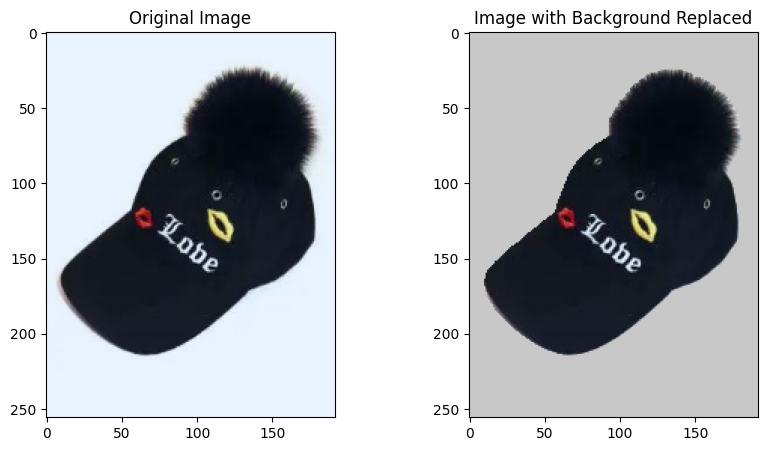

In [50]:
# Загрузка тестового изображения и предсказанной маски
n = np.random.choice(len(test_dataset))

image, gt_mask = test_dataset[n]
gt_mask = gt_mask.squeeze()

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model(x_tensor)
pr_mask = pr_mask.squeeze().cpu().detach().numpy()

label_mask = np.argmax(pr_mask, axis=0)

# Визуализация предсказаний если нужно проверить качество полученной маски
#visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

# Нормализация изображения
image = normalize_image(image)

# Применение функции замены фона
new_image = replace_background(image, label_mask)

# Визуализация результата
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.transpose(1, 2, 0))
ax[0].set_title('Original Image')
ax[1].imshow(new_image)
ax[1].set_title('Image with Background Replaced')
plt.show()


In [52]:
def dummy_func(color = (200,200,200)):
    # Загрузка тестового изображения и предсказанной маски
    n = np.random.choice(len(test_dataset))

    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()

    label_mask = np.argmax(pr_mask, axis=0)

    # Визуализация предсказаний если нужно проверить качество полученной маски
    #visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

    # Нормализация изображения
    image = normalize_image(image)

    # Применение функции замены фона
    new_image = replace_background(image, label_mask, color)

    # Визуализация результата
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image.transpose(1, 2, 0))
    ax[0].set_title('Original Image')
    ax[1].imshow(new_image)
    ax[1].set_title('Image with Background Replaced')
    plt.show()

Не сложно реализовать выбор цвета на одноцветный фон из предложенных

Выберите один из вариантов фона на который хотите изменить. Для этого напишите соответствующую цифру:
      Белый: 0, Мятный: 1, Сиреневый: 2, Лавандовый: 3, 
      Кремовый: 4, Желтый: 5, Персиковый: 6, 
      Голубой: 7, Серый: 8, Розовый: 9


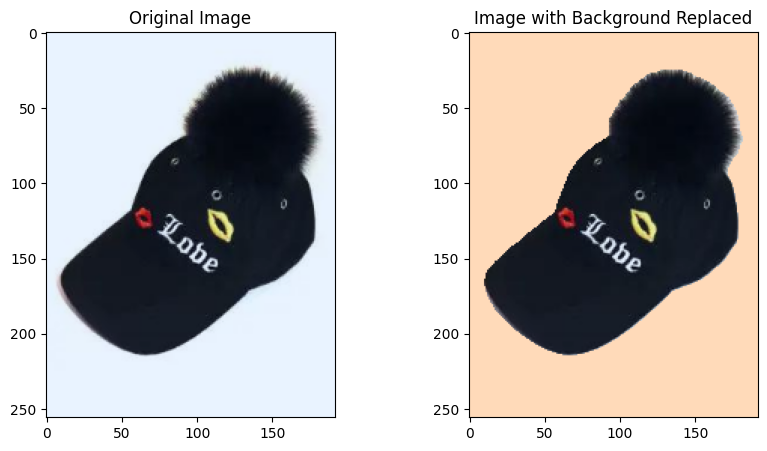

In [72]:
print('''Выберите один из вариантов фона на который хотите изменить. Для этого напишите соответствующую цифру:
      Белый: 0, Мятный: 1, Сиреневый: 2, Лавандовый: 3, 
      Кремовый: 4, Желтый: 5, Персиковый: 6, 
      Голубой: 7, Серый: 8, Розовый: 9''' )
x = int(input())
def get_color_rgb(index):
    colors = [
        (255, 255, 255),  # Белый
        (189, 252, 201),  # Пастельный мятный
        (216, 191, 216),  # Пастельный сиреневый
        (230, 240, 255),  # Пастельный лавандовый
        (255, 253, 208),   # Пастельный кремовый
        (255, 255, 224),  # Пастельный желтый
        (255, 218, 185),  # Пастельный персиковый
        (173, 216, 230),  # Пастельный голубой
        (128, 128, 128),  # Серый
        (255, 182, 193)   # Пастельный розовый
    ]
    
    if 0 <= index < len(colors):
        return colors[index]
    else:
        print('некорректный ввод, по умолчанию серый фон')
        return None 

dummy_func(get_color_rgb(x))

Или использование одного из предзагруженных вариантов 

In [99]:
def replace_background_with_texture(image, mask, texture_image):
    # Преобразуем изображение обратно в HWC формат
    image_hwc = image.transpose(1, 2, 0)
    
    # Изменим размер текстуры под размер исходного изображения
    texture_resized = cv2.resize(texture_image, (image_hwc.shape[1], image_hwc.shape[0]))
    
    # Создаем трехканальную маску
    mask_3ch = np.stack([mask] * 3, axis=-1)
    
    # Наложение маски: объект оставляем, фон заменяем на текстуру
    output_image = np.where(mask_3ch == 1, image_hwc, texture_resized)
    
    return normalize_image(output_image)

def our_texture(texture_path = 'textures\\gradient.jpg'):
    # Загрузка тестового изображения и предсказанной маски
    n = np.random.choice(len(test_dataset))

    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()

    label_mask = np.argmax(pr_mask, axis=0)

    # Визуализация предсказаний если нужно проверить качество полученной маски
    #visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

    # Нормализация изображения
    image = normalize_image(image)

    # Применение функции замены фона
    new_image = replace_background_with_texture(image, label_mask, texture_path)

    # Визуализация результата
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image.transpose(1, 2, 0))
    ax[0].set_title('Original Image')
    ax[1].imshow(new_image)
    ax[1].set_title('Image with Background Replaced')
    plt.show()


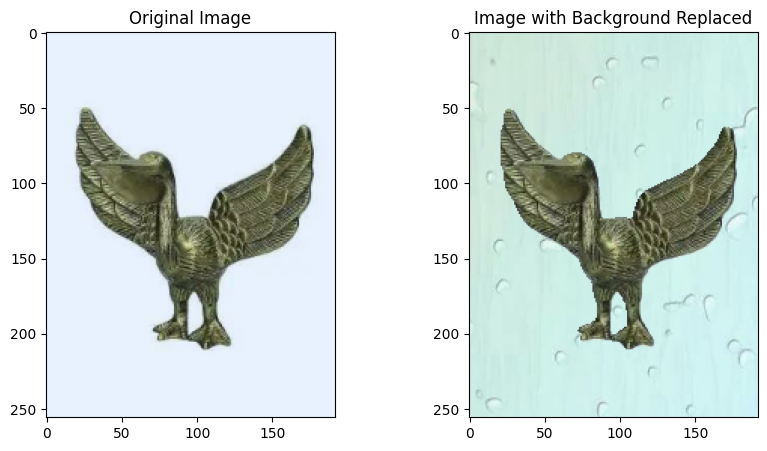

In [105]:
texture = cv2.imread('textures\\gradient.jpg')
our_texture(texture)

Можно обернуть в функцию с выбором фона из предзагруженных:

Выберите один из вариантов фона на который хотите изменить. Для этого напишите соответствующую цифру:
      Голубой градиент - 0
      Керамогранит светлый - 1
      Перья - 2
      Ткань - 3


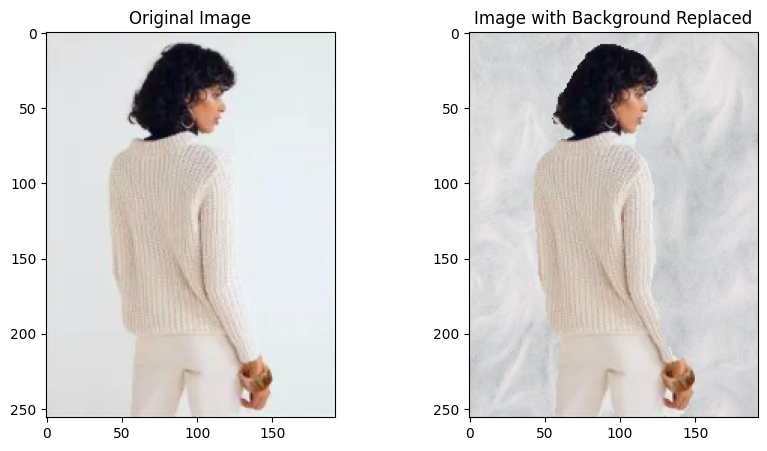

In [103]:
print('''Выберите один из вариантов фона на который хотите изменить. Для этого напишите соответствующую цифру:
      Голубой градиент - 0
      Керамогранит светлый - 1
      Перья - 2
      Ткань - 3''' )

x = int(input())

def get_texture(index):
    textures = [
        'textures\\gradient.jpg',
        'textures\\keramogranit-svetlyj.jpg',
        'textures\\periya.jpg',
        'textures\\tkan_bezevii.jpg'

    ]
    
    if 0 <= index < len(textures):
        return textures[index]
    else:
        print('некорректный ввод')
        return None 

texture = normalize_image(cv2.imread(get_texture(x)))
our_texture(texture)

Можно даже придумать неоднородный фон, градиент или шумы

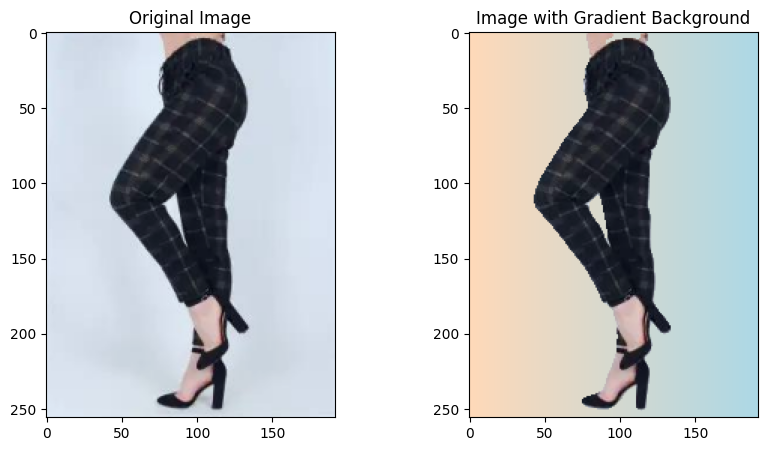

In [120]:
def create_gradient_background(image_shape, color1=(200, 200, 200), color2=(255, 255, 255)):
    height, width, _ = image_shape
    # Создание градиента
    gradient = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(3):  # Для каждого канала (RGB)
        gradient[:, :, i] = np.linspace(color1[i], color2[i], width)
    return gradient


def replace_background(image, mask, background_color=(255, 218, 185)):
    image_hwc = image.transpose(1, 2, 0)
    background = create_gradient_background(image_hwc.shape, background_color, (173, 216, 230))
    binary_mask = (mask > 0).astype(np.uint8)
    mask_3ch = np.stack([binary_mask] * 3, axis=-1)
    output_image = image_hwc * mask_3ch + background * (1 - mask_3ch)
    
    return output_image

n = np.random.choice(len(test_dataset))
image, gt_mask = test_dataset[n]
gt_mask = gt_mask.squeeze()
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model(x_tensor)
pr_mask = pr_mask.squeeze().cpu().detach().numpy()
label_mask = np.argmax(pr_mask, axis=0)
image = normalize_image(image)


new_image = replace_background(image, label_mask)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.transpose(1, 2, 0))
ax[0].set_title('Original Image')
ax[1].imshow(new_image)
ax[1].set_title('Image with Gradient Background')
plt.show()
